In [187]:
import dotenv
dotenv.load_dotenv()

True

In [176]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


from typing import List, Optional

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph, START

def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    
    system_prompt += """\nWork autonomously according to your specialty, using the tools available to you.
    Do not ask for clarification.
    Your other team members (and other teams) will collaborate with you with their own specialties.
    
    Make sure you respond in the following json format: \"choice_made\":string, \"reason\": string """
    
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                "Select one of: {options} "
                "\nIf the conclusion is reached, select FINISH."
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

In [177]:
from langchain.utilities.tavily_search import TavilySearchAPIWrapper
from langchain.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(api_wrapper=TavilySearchAPIWrapper())


In [178]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

In [179]:
from langchain_openai import ChatOpenAI
openai_model = ChatOpenAI(temperature=0)


In [180]:
from langgraph.prebuilt import ToolNode

available_tools = [tavily_tool, wikipedia]
tools_node = ToolNode(available_tools)

In [181]:

from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
    AIMessage
)

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}


from typing_extensions import TypedDict, Annotated, operator
class TeamState(TypedDict):
    team_members: List[str]
    messages: Annotated[List[BaseMessage], operator.add]
    next: str


In [182]:
import functools
market_analysis_agent = create_agent(
                 openai_model, 
                 available_tools, 
                 "You're a market expert of London City. And you work on our real estate company as a market analysis agent."
                )
market_analysis_agent_node = functools.partial(agent_node, agent=market_analysis_agent, name="Market Analysis Agent")


financial_analysis_agent = create_agent(
                 openai_model, 
                 available_tools, 
                 "You're a financial expert. And you work on our real estate company as a financial analysis agent."
                )
financial_analysis_agent_node = functools.partial(agent_node, agent=financial_analysis_agent, name="Financial Analysis Agent")


location_agent = create_agent(
                 openai_model, 
                 available_tools, 
                 "You're a location strategy expert. And you work on our real estate company as a location strategy and planning helper agent."
                )
location_agent_node = functools.partial(agent_node, agent=location_agent, name="Location Strategy agent")


orchestrator = create_team_supervisor(
                 openai_model, 
                 "You're a intelligent general strategist of a real estate and rental advising company. "
                 "And you've a following coworkers to help you out with {team_members}."
                 "Out of two locations, you take each of their opinion to pick the best out with reasoning. "
                 ,
                ["MarketAnalysisAgent", "FinancialAnalysisAgent", "LocationStrategist"]
                )
# orchestrator_node = functools.partial(agent_node, agent=orchestrator, name="Orchestrator")


In [183]:

from langgraph.graph import END, StateGraph, START

workflow = StateGraph(TeamState)

workflow.add_node("MarketAnalysisAgent", market_analysis_agent_node)
workflow.add_node("FinancialAnalysisAgent", financial_analysis_agent_node)
workflow.add_node("LocationStrategist", location_agent_node)
workflow.add_node("Orchestrator", orchestrator)
# workflow.add_node("tools",tools_node)



workflow.add_edge("MarketAnalysisAgent", "Orchestrator")
workflow.add_edge("FinancialAnalysisAgent", "Orchestrator")
workflow.add_edge("LocationStrategist", "Orchestrator")

# workflow.add_edge("tools", "MarketAnalysisAgent")
# workflow.add_edge("tools", "FinancialAnalysis")
# workflow.add_edge("tools", "LocationStrategist")

workflow.add_conditional_edges("Orchestrator", 
                               lambda x: x["next"],
                               {
                                   "MarketAnalysisAgent": "MarketAnalysisAgent", 
                                   "FinancialAnalysisAgent": "FinancialAnalysisAgent",
                                   "LocationStrategist":"LocationStrategist",
                                   "FINISH": END
                               }
                        )


workflow.add_edge(START, "Orchestrator")

graph = workflow.compile()

In [189]:
graph.invoke("which is better site for a tech company office, islington or westminister")

{'Orchestrator': {'next': 'FINISH'}}
----


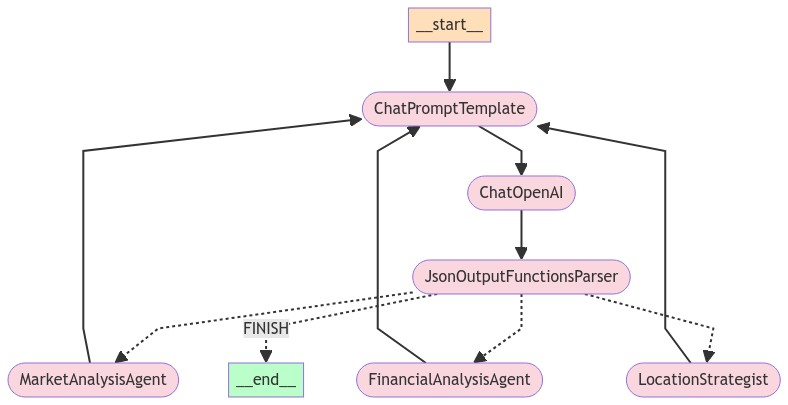

In [185]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [186]:
for s in decision_graph.stream(
    "which is better site for a tech company office, islington or westminister?", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Orchestrator': {'next': 'LocationStrategist'}}
---
{'LocationStrategist': {'messages': [HumanMessage(content='{\n  "choice_made": "Westminster",\n  "reason": "Westminster is a prime location in London, known for its proximity to government offices, cultural landmarks, and prestigious institutions. It attracts a high number of tourists and business professionals, making it an ideal location for a tech company looking to establish a presence in a vibrant and central area with excellent networking opportunities."\n}', name='Location Strategy agent')]}}
---


BadRequestError: Error code: 400 - {'error': {'message': "Invalid 'messages[2].name': string does not match pattern. Expected a string that matches the pattern '^[a-zA-Z0-9_-]+$'.", 'type': 'invalid_request_error', 'param': 'messages[2].name', 'code': 'invalid_value'}}